Populating the interactive namespace from numpy and matplotlib
Beta: [-4.98553996  2.99384718  1.17165055  0.0103564 ]
Beta Std Error: [ 0.01558912  0.01167449  0.00689039  0.0004825 ]
Beta Covariance: [[  3.18476817e-09  -2.23962389e-09  -4.41059202e-10   5.36793553e-11]
 [ -2.23962389e-09   1.78612000e-09   2.22882799e-10  -2.02523733e-11]
 [ -4.41059202e-10   2.22882799e-10   6.22189533e-10  -3.00641370e-11]
 [  5.36793553e-11  -2.02523733e-11  -3.00641370e-11   3.05092135e-12]]
Residual Variance: 76307.195639
Inverse Condition #: 0.015756256087
Reason(s) for Halting:
  Sum of squares convergence


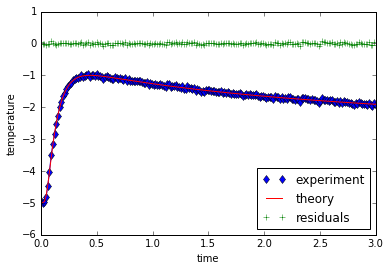

('Errors in percent are :', array([-0.28920082, -0.20509415,  0.14107227,  3.5639956 ]))


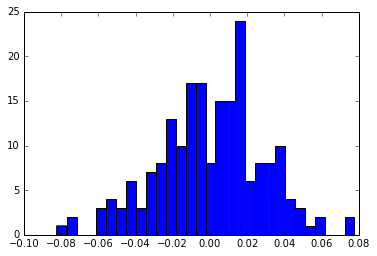

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 22 10:51:51 2015

@author: Jozef
"""
%pylab inline

import numpy as np
import scipy.special as scs
from scipy.optimize import brenth
import scipy.odr.odrpack as odrpack
import os


## define values of parameters (CGS units)
a = 1 #  thermal diffusivity
L = 1# sample thickness
R = 6.35 # sample radius
IRI = 0.0 # irradiated radius inner
IRO = 5.35 # irradiated radius outer
VRI = 0.0 # viewed radius inner
VRO = 4.1 # viewed radius outer

#dimensionless radii
IRID = IRI/R
IROD = IRO/R
VRID = VRI/R
VROD = VRO/R

# Theoretical values
Biot_theor  = 0.01 # dimensionless parameter m
td_theor = 1.17 # thermal diffusivity
Tmax_theor = 3.0  # Tmax (adiabatic)
baseline_theor = -5.0

theors = [baseline_theor, Tmax_theor, td_theor, Biot_theor]

# Biot numbers, front, rear, radial
Bio = [Biot_theor, Biot_theor, Biot_theor*L/R]


def rootsearch(f,a,b,Bio,dx):
    x1 = a; f1 = f(a, Bio)
    x2 = a + dx; f2 = f(x2, Bio)
    while f1*f2 > 0.0:
        if x1 >= b:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2, Bio)
    return x1,x2


def mroots(f, Bio, a, b, eps=1e-2):
    #print ('The roots on the interval [%f, %f] are:' % (a,b))
    i=0
    myroots=[]
    while 1:
        x1,x2 = rootsearch(f,a,b,Bio,eps)
        if x1 != None:
            a = x2
            #root = bisect(f,x1,x2,1)
            root = brenth(f,x1,x2, Bio, xtol=1e-16)
            if root != None:
                pass
       #     print ('root',i, root, f(root, Bio))
            myroots.append(root)
            i = i+1
        else:
            #print ('\nDone')
            return myroots
            
            break


def funA(x,Bio): 
    return (x*x-Bio[0]*Bio[1])*np.sin(x) - (Bio[0]+Bio[1])*x*np.cos(x)
    
def funR(x,Bio): 
    return (x*scs.j1(x) - Bio[2]*scs.j0(x))

gamas = mroots(funA, Bio, 0.0001, 200)
betas = mroots(funR, Bio, 0.0001, 200)


def flash1D(t, a):
    suma =0.0
    for n in range(1, 50):
        suma = suma + (-1)**n*np.exp(-((n*np.pi)**2*a*t/L**2))
    return (1+2.0*suma)

def flash1DHL(t, a, Bio, gamas): 

    Bi1=Bio[0]
    Bi2=Bio[1]

    g2 = list(np.array(gamas)**2)
    suma=0.0
    for i in range(0, len(gamas)):
       suma = suma + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*t/L**2)  
    
    return suma
 
def flash2DHL(t, a, Bio, gamas, betas): 

    Bi1=Bio[0]
    Bi2=Bio[1]
    Bi3=Bio[2]
    
    g2 = list(np.array(gamas)**2)
    b2 = list(np.array(betas)**2)

    sumaA = 0.0
    for i in range(0, len(gamas)):
       sumaA = sumaA + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*t/L**2)

    sumaR = 0.0
    for i in range(0, len(betas)):
        sumaR = sumaR + 4*(VRID*scs.j1(betas[i]*VRID)
        -VROD*scs.j1(betas[i]*VROD))*(IRID*scs.j1(betas[i]*IRID)
        -IROD*scs.j1(betas[i]*IROD))/((b2[i]+Bi3**2)*scs.j0(betas[i])**2
        *(IROD**2-IRID**2)*(VROD**2-VRID**2))*np.exp(-b2[i]*a*t/R**2)
    
    return sumaA * sumaR


from matplotlib import pyplot
N=200
time = np.linspace(0.001,3.,N)
noise = 0.01
temperature=baseline_theor+Tmax_theor*(flash2DHL(time, td_theor, Bio, gamas, betas) 
    + np.random.normal(0,noise,N))
pyplot.plot(time, temperature)


 ## ODRPACK application
## get input ##
filename="results2Dodr.txt"
 
## delete only if file exists ##
if os.path.exists(filename):
    os.remove(filename)
else:
    print("Sorry, I can not remove %s file." % filename)
    
def f2DHL(B, x):
    Bio = [B[3], B[3], B[3]*L/R]
    gamas = mroots(funA, Bio, 0.0001, 200)
    betas = mroots(funR, Bio, 0.0001, 200) 
    return B[0]+B[1]*flash2DHL(x, B[2], Bio, gamas, betas) 
    
flash = odrpack.Model(f2DHL)

mydata = odrpack.RealData(time, temperature, sx=0.00001, sy=0.0001)

myodr = odrpack.ODR(mydata, flash, beta0=[-4.,4.5, 1.3, 0.02], ifixb=[1,1,1,1],
                    iprint=6616, rptfile=filename )
myoutput = myodr.run()
myoutput.pprint()

B = myoutput.beta
Bio=[B[3],B[3],B[3]*L/R]
gamas = mroots(funA, Bio, 0.0001, 200)
betas = mroots(funR, Bio, 0.0001, 200) 
theory = B[0]+B[1]*flash2DHL(time, B[2], Bio, gamas, betas) 
pyplot.plot(time, temperature, 'bd', label="experiment")
pyplot.plot(time, theory,'r', label="theory")
residuals = temperature - theory
pyplot.plot(time, residuals, 'g+', label="residuals")
pyplot.xlabel("time")
pyplot.ylabel("temperature")
pyplot.legend(loc=4)
pyplot.show()

pyplot.hist(residuals, 30)

errors = (B-theors)/theors*100 
print('Errors in percent are :',errors)
